Right-click the "Open in Colab" badge to see all content. 

Don't forget to "Save a Copy in Drive" before you start working, so you don't lose your work!  

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1n6wMrXRRY8JafJm2Hm4-oxSAw_FcHJ8K?usp=sharing)



# Assignment: Generative Adversarial Networks (GANs)

> Deep Learning and AI Ethics, Fall 2021, [Dr. Scott H. Hawley](https://hedges.belmont.edu)

**NOTE: If you haven't already completed Lesson 13, ["Overview of GANs"](https://github.com/drscotthawley/DLAIE/blob/main/Lessons/13_GAN_Overview.ipynb), do that first!  Then come back.**

In [ ]:
#from IPython.display import YouTubeVideo, display  # might make a video if I have time

### What to expect from this Assignment: 
This coding assignment will be a synthesis of Coursera's approach (of making you write everything yourself), vs. fastai's approach (of supplying most things for you): You will write the components of the GAN model yourself using "raw PyTorch," then connect them together with fastai, and then do training via fastai's training loop.

**GANs can take a while to train.** You will not be graded on the training itself, rather just the parts leading up to it.

*Credits: Many parts of this code are original, parts are resynthesized from the DCGAN assignment of the [Coursera GAN Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans) taught by [Sharon Zhou](https://twitter.com/realSharonZhou), and other parts of the code are borrowed from [fastai (W)GAN documentation](https://docs.fast.ai/vision.gan.html). Borrowed figures are cited with attribution.* 

## Setup Environment & Imports
You should probably restart the runtime after this next code cell

In [2]:
%pip install mrspuff wandb -Uqq 
! [ -e /content ] && pip install -Uqq fastai  # Colab only: upgrade fastai.

Note: you may need to restart the kernel to use updated packages.


In [3]:
from mrspuff.utils import on_colab
from PIL import Image, UnidentifiedImageError
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
#from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from fastai.vision.all import * 
from fastai.data.transforms import get_image_files
from fastai.callback.wandb import *
from pathlib import Path 
from glob import glob 
import wandb

torch.manual_seed(0) # for testing purposes

In [4]:
wandb.login()

wandb: Currently logged in as: drscotthawley (use `wandb login --relogin` to force relogin)


True

## Get the Data
We will use the [Anime Face Dataset](https://github.com/bchao1/Anime-Face-Dataset).  The URL for this is https://drive.google.com/file/d/1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI/view?usp=sharing. To get the data, click on that sharing URL, then in the upper right click the triangle icon for **"Add shortcut to Drive"**, then choose "My Drive" and click "Add Shortcut".  After that, we can mount it and make sure it's there, as follows:

In [5]:
tgzfile = "data.tgz"
basedir = "."

if on_colab(): # On colab: mount from Google Drive
    from google.colab import drive
    basedir = '/content/'
    drive.mount('/content/drive')   # this will produce a link to an authorization code to copy and paste in a text box
    tgzfile = "/content/drive/My\ Drive/" + tgzfile
else:  # Local machine: download it from Google Drive if needed
    ! [ ! -e {tgzfile} ] && pip install gdown -qq && gdown --id 1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI

!ls -lh {tgzfile}  # data.tgz is the name of the Anime Faces dataset

-rw-rw-r-- 1 shawley shawley 362M Nov 20 23:16 data.tgz


When we expand the archive (via `tar`), it will go into a directory called `cropped/` which will contain 518 MB of images:

In [6]:
!tar xfz {tgzfile}
!du -sh cropped  # show us how many megabytes it is

561M	cropped


Let's look at a few images:  *Oh, and we should remove any unloadable images*

There are initally 63632 images.
After cleaning, there are now 63569 images.


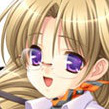

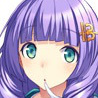

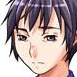

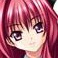

In [7]:
path = Path(f"{basedir}/cropped")  
fnames = get_image_files(path)
print(f"There are initally {len(fnames)} images.")

def clean(fnames):
    "apparently there are some bad images, so 'clean the list"
    for test_file in fnames:
        try:
            test = Image.open(test_file)
        except UnidentifiedImageError:
            fnames.remove(test_file)  # remove that filename from the list
            test_file.unlink() # delete the image so we don't have to deal with this again
    return fnames

fnames = clean(fnames)
print(f"After cleaning, there are now {len(fnames)} images.")

for f in fnames[:5]:
    img = Image.open(f)
    display(img)

Note that these images are different sizes.  We will define a dataloader that resizes and crops them all to make them the same size. That's next!   

Later we'll use fastai and can use their dataloaders, but for the first part of this Assignment, where you write the model components yourself, it works better if we use "raw PyTorch" dataloaders.  To do that, we'll define a PyTorch Dataset object and the image transforms it should us while loading images:


In [12]:
# Define a PyTorch Dataset
class AnimeDataset(torch.utils.data.Dataset):
    def __init__(self, path, img_size):
        self.img_files = get_image_files(path) 
        self.img_size = img_size

        self.transform = T.Compose([ T.ToPILImage(), T.Resize((self.img_size,self.img_size)),
        T.RandomHorizontalFlip(), T.ToTensor() ])  # the ToTensor is kind of redundant, but fingers crossed. 

    def __len__(self): # returns the number of image files
        return len(self.img_files)

    def __getitem__(self, index):   # returns one data item: a normalized, cropped, tensor-ified image
        # Select sample
        try:  # this try/except just guards against "bad" image files; should be unnecessary
            image = Image.open(self.img_files[index])   # read from the disk
        except UnidentifiedImageError:
            image = Image.open(self.img_files[index+1]) # read from the disk
        nparray = np.moveaxis(np.array(image), -1, 0)   # move the color channels first instead of last
        image = torch.from_numpy(nparray)               # convert to torch tensor
        X = self.transform(image)       # this inherits from super, torch Dataset class
        return X

    
img_size = 64
batch_size = 128 

dataset = AnimeDataset(path, img_size=img_size)

torch.manual_seed(0) # for making the shuffle reproduciple in case we want that.

# Define a dataloader from the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

And here's a little utility program to show how our loaded images appear

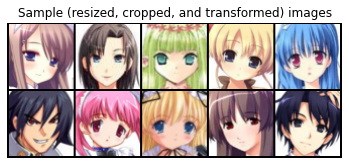

In [14]:
def show_batch(image_tensor, num_images=10, size=(3, img_size, img_size), label=''):
    image_unflat = image_tensor.detach().cpu().view(-1, *size) # move color channels to last dimension
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')  # remove tick marks
    plt.title(label)
    plt.show()
    
batch = next(iter(dataloader))
show_batch(batch, label='Sample (resized, cropped, and transformed) images')

## Build the Model 

### The Generator

Below is a schematic picture of the generator you'll be making. We'll describe the parts as we go.

<img src="https://github.com/drscotthawley/DLAIE/blob/main/images/generator_schematic.png?raw=true" alt="schematic of generator" width="550px">

#### Exercise 1: The noise initialization/input 
The generator will be initialized with -- i.e., the "input" to the generator will be -- a 
1-D vector of noise of length `z_dim`.  Since we are working it batches of size `batch_size`, that will mean the input will be a matrix of random numbers of size `batch_size` $\times$ `z_dim`.  In the following (one-liner!) function, return a tensor of random numbers of the desired dimensions. (Hint: use [`torch.randn()`](https://pytorch.org/docs/stable/generated/torch.randn.html).)

In [15]:
### GRADED EXERCISE 1
def get_noise(batch_size, z_dim, device='cpu'):
    #### YOUR CODE BELOW (it's a one-liner)
    return                                       # fill in what's to be returned
### END GRADED EXERCISE 

In [16]:
# Here's some code to test your work
noise = get_noise(1247, 34763)  # just some arbitrary dimensions
print("noise.shape =",noise.shape)
assert noise.mean().abs() < 1e-3, f"noise.mean() should be close to zero but it's {noise.mean()}"
assert (noise.var() - 1).abs() < 1e-3, f"noise.var() should be close to one but it's {noise.var()}"
print("Success!")

noise.shape = torch.Size([1247, 34763])


Expected output: 
```
noise.shape = torch.Size([1247, 34763])
```

#### Exercise 2: Add dimensions to the noise
We're going to take our `batch_size` $\times$ `z_dim` initialization and add two more unit-length dimensions to it on the end, so that the matrix will have a shape `[batch_size, z_dim, 1, 1]`.  The `1,1` will be like a tiny 1 $\times$ 1 image with `z_dim` color channels. In order for compatibility later on (with fastai), we won't just add *two* more dimensions, but rather an arbitrary amount `n_dim` which will default to two. 

[There are various ways to add dimenions](https://stackoverflow.com/questions/65470807/how-to-add-a-new-dim-to-a-a-pytorch-tensor). One is with slicing and placing "`None`" wherever you want a new axis. Another way is to use a  Pytorch [view](https://pytorch.org/docs/stable/tensor_view.html). Still another is to invoke a pytorch tensor's [`.unsqueeze()`](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) method. Whichever way you choose to do it, write a routine below that will tack on `n_dim` unit-length dimensions on the end of our noise vector.

In [17]:
### GRADED EXERCISE 2
def unsqueeze_noise(noise, n_dim=2): 
    "Add unit-length dims to noise. This makes 1x1 images where all the noise is in the 'channels' dimension"
    ### YOUR CODE BELOW (it's a one-liner)
    return                                                # fill in what's to be returned
### END GRADED EXERCISE

In [18]:
# Student-facing testing code for unsqueeze_noise 

unsq_noise = unsqueeze_noise(noise)
print("unsq_noise.shape = ",unsq_noise.shape)

def compare_shapes(a_tensor, shape_as_list):
    "since lots of our tests are going to be comparing shapes, I just wrote this little utility"
    assert list(a_tensor.shape) == shape_as_list, f"{list(a_tensor.shape)} != {shape_as_list}"

compare_shapes(unsq_noise, list(noise.shape)+[1]*2)
compare_shapes(unsqueeze_noise(torch.randn(345,678), n_dim=4), [345,678,1,1,1,1])
print("Success!")

unsq_noise.shape =  torch.Size([1247, 34763, 1, 1])
Success!


#### Exercises 3 and 4: Expanding the 'image' via Transposed Convolutions

What is "transposed convolution"?  First, let's review regular convolution.
You'll recall that with ordinary convolution operators, there are the parameters that define exactly how it will be performed:

* `kernel_size` ($k$): how big the convolution kernel or "window" will be, in pixels
* `stride` ($s$): how many pixels to move between each kernel-image weighted sum
* `padding` ($p$): how many pixels to place in a border around the original image, to allow the convolution to output at all locations.

The following images and animations from [Aqeel Anwar's post on the subject](https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11) show are illuminating: 

![conv example](https://miro.medium.com/max/1250/1*gYAQUBj741P5-gbuboXfMA.png)
<table style="border:none">
    <tr>
        <td><img src="https://miro.medium.com/max/1250/1*YvlCSNzDEBGEWkZWNffPvw.gif"></td>
        <td><img  src="https://miro.medium.com/max/1250/1*gXAcHnbTxmPb8KjSryki-g.gif"></td>
    </tr>
        <td><img src="https://miro.medium.com/max/1250/1*gXAcHnbTxmPb8KjSryki-g.gif"></td>
        <td><img src="https://miro.medium.com/max/1250/1*34_365CJB5seboQDUrbI5A.gif"></td>
    <tr>
    </tr>
</table>

Given values for $k$, $s$, and $p$, then the output dimension $o$ (say, along one axis) in terms of input dimension $i$ is given by this equation:

$$ o = {i + 2p - k\over s} + 1\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1) $$

That's for $regular$ convolution. "Transposed" convolution is kind of like using a "fractional stride", only the way people write and talk about is, rather than use fractional strides, to use the variables "in reverse": We use the same variables as before, and use them to apply *as if* a convolution were being performed.  Let's look at Anwar's animations of transposed convolution:

<table style="border:none">
    <tr>
        <td><img src="https://miro.medium.com/max/1250/1*SpxCUPzNfb9C8TiAcrRr5A.gif"></td>
        <td><img  src="https://miro.medium.com/max/1250/1*gff0oa2iPygyCEjj7Fb3yg.gif"></td>
    </tr>
        <td><img src="https://miro.medium.com/max/1250/1*WaBzh5OkmD-9EBLy5aXiug.gif"></td>
        <td><img src="https://miro.medium.com/max/1250/1*L_hJRnywTpeTFJAaVZTRfQ.gif"></td>
    <tr>
    </tr>
</table>

The equation for the sizes of outputs is *identical* to the one above except with the inputs and outputs reversed.  Put differently, if we solve equation (1) for $i$, we get:

$$ i = (o-1)s + k -2p \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  $$

and now we can just relabel those *regular convolution* input and output image sizes $i$ and $o$ and to be the opposites of the *transposed convolution* sizes $o' (=i)$ and $i' (=o)$ respectively: 

$$ o' = (i'-1)s + k -2p \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (2) $$

Or, rather, to keep from getting mixed up between what's an input and what's an output, I wrote the following calculator to help you figure out expanding image sizes, using "big" and "small" instead of $o'$ and $i'$, respectively: 

In [19]:
def calc_big(small, stride=2, kernel_size=4, padding=1): # sizing of transposed convolution output
    return (small-1)*stride + kernel_size - 2*padding

In [20]:
small = 1
for i in range(6):
    big = calc_big(small)
    print(f"small: {small} -> big: {big}")
    small = big

small: 1 -> big: 2
small: 2 -> big: 4
small: 4 -> big: 8
small: 8 -> big: 16
small: 16 -> big: 32
small: 32 -> big: 64


> Hint: we'll want to use *exactly* these sizes later in Exercise 4.  The above values for `kernel_size`, `stride` and `padding` used in `calc_big()` will serve you well!

**Generator Block:** The generator will be made of a `nn.Sequential()` series of "blocks" that do the same things over and over.  For all the block except the final blocks, we'll want to make blocks that do 3 things:

1. A `nn.ConvTranspose2d` operation, that will convert input channel sizes (e.g. z_dim) to output channel sizes (e.g. 3 for last layer, or "some big number" otherwise)
2. A `nn.BatchNorm2d` that takes an an argument the number of output channels. 
3. Some nonlinear activation. We'll use `nn.ReLU()`. 

For the last block, we'll skip the BatchNorm and ReLU but will add a `nn.Tanh()` activation. 

Fill in the blanks below to define your `generator_block()`.  Later in Exercise 4, we'll stack these blocks to make the generator. 

In [30]:
### GRADED EXERCISE 3
def generator_block(input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_block=False):
    # Build the neural block
    if not final_block:
        return nn.Sequential(
            #### YOUR CODE HERE (3 lines)

            
            
            #### END YOUR CODE
        )
    else: # Final block
        return nn.Sequential(
            #### YOUR CODE HERE (2 lines)

            
            #### END YOUR CODE 
        )
### END GRADED EXERCISE

In [31]:
# Student-facing tests for generator_block
test_batch_size, z_dim = 83, 121

gb1 = generator_block(z_dim, 13)
assert len(gb1) == 3, "should have exactly 3 layers"
in1 = unsqueeze_noise( get_noise(test_batch_size, z_dim) )
out1 = gb1(in1)
compare_shapes(out1, [test_batch_size, 13, 2, 2])
assert isinstance(gb1[-1], nn.ReLU), 'activation should be ReLU'


gb2 = generator_block(256, 512, kernel_size=2)
in2 = torch.rand(test_batch_size, 256, 28, 28)
out2 = gb2(in2)
compare_shapes(out2, [test_batch_size, 512, 54, 54])

gb3 = generator_block(256, 512, kernel_size=2, padding=0, stride=1, final_block=True)
assert len(gb3) == 2, "final block should have exactly 2 layers"
in3 = torch.rand(test_batch_size, 256, 28, 28)
out3 = gb3(in3)
compare_shapes(out3, [test_batch_size, 512, 29, 29])
assert isinstance(gb3[-1], nn.Tanh), 'activation should be Tanh'
print("Success!")

In [32]:
# defining this here so we can use it in the_generator(), below. Leave this cell alone
class AddChannels(Module):
    "utility layer: this just does the 'unsqueeze_noise' inside a PyTorch module"
    def __init__(self, n_dim):  # note fastai will expect n_dim to be an arg, not a kwarg
        self.n_dim = n_dim
    def forward(self, x): 
        return unsqueeze_noise(x, n_dim=self.n_dim)

In [33]:
### GRADED EXERCISE 4
def the_generator(z_dim=100, img_chan=3, hidden_dim=64):
    return nn.Sequential(
        AddChannels(2),
        #### YOUR CODE BELOW: 6 gen_block() calls ####

        
        
        
        
        
        
        #### END OF YOUR CODE ####
    )
### END OF GRADED EXERCISE

As part of testing / check-your-work code, we'll defite a handy utility, `show_ct_shapes()`, that will print out the shape changes made inside your generator. You can use this to check whether you made it correctly:

In [34]:
# Student-facing testing code for the_generator() 

def show_ct_shapes(net, small=1, log=True):
    """Utility: Shows changes to 'internal' image shapes in a model, due to ConvTranspose2d's' """
    if log: print("ConvTranspose2d transformations of 'image' shapes:")
    out_shapes = []  # list of shapes of the 'output' of each convtranspose2d
    for block in net.children():
        if isinstance(block, nn.Sequential): 
            for l in block.children():
                if isinstance(l, nn.ConvTranspose2d):
                    ic, oc = l.in_channels, l.out_channels
                    k,s,p = l.kernel_size[0], l.stride[0], l.padding[0]
                    big = calc_big(small, kernel_size=k, stride=s, padding=p)
                    if log: print(f"({ic},{small},{small}) -> ({oc},{big},{big})")
                    out_shapes.append((oc,big,big))
                    small = big
    return out_shapes 

gen = the_generator()
shapes= show_ct_shapes(gen)
print("shapes = ",shapes)
# make sure these are as expected
assert shapes == [(512, 2, 2), (256, 4, 4), (128, 8, 8), (64, 16, 16), (64, 32, 32), (3, 64, 64)]
print("Success!")

ConvTranspose2d transformations of 'image' shapes:
(100,1,1) -> (512,2,2)
(512,2,2) -> (256,4,4)
(256,4,4) -> (128,8,8)
(128,8,8) -> (64,16,16)
(64,16,16) -> (64,32,32)
(64,32,32) -> (3,64,64)
shapes =  [(512, 2, 2), (256, 4, 4), (128, 8, 8), (64, 16, 16), (64, 32, 32), (3, 64, 64)]
Success!


Good for you! 

Now, actually, based on a little experimentation, it turns out the following generator works a bit better than the one you just defined above.  We could use either one, but so that you can see the best images (and to make sure you don't get stuck if you can't get `the_generator()` working), we'll use this one as we move on:

In [35]:
def better_generator(z_dim=100, im_chan=3, hidden_dim=64):
    "based on what fastai's basic_generator() does internally"
    return nn.Sequential(
        AddChannels(2),
        gen_block(z_dim, hidden_dim * 8, stride=1, padding=0),
        gen_block(hidden_dim * 8, hidden_dim * 4),
        gen_block(hidden_dim * 4, hidden_dim*2),
        gen_block(hidden_dim*2, hidden_dim),
        gen_block(hidden_dim, hidden_dim, kernel_size=3, stride=1),
        gen_block(hidden_dim, im_chan, final_block=True),
    )

gen = better_generator()
shapes= show_ct_shapes(gen)
assert shapes[-1] == (3,64,64)  # make sure final output is the right shape
print("Success!")

ConvTranspose2d transformations of 'image' shapes:
(100,1,1) -> (512,4,4)
(512,4,4) -> (256,8,8)
(256,8,8) -> (128,16,16)
(128,16,16) -> (64,32,32)
(64,32,32) -> (64,32,32)
(64,32,32) -> (3,64,64)
Success!


### Discriminator / Critic

The discriminator is a good old regular convolutional neural network.  Instead of pooling layers, we just use strided convolutions (of stride=2). 

In [37]:
### GRADED EXERCISE 5
def discriminator_block(input_channels, output_channels, kernel_size=4, 
                        stride=2, padding=1, final_block=False):
    # Build the neural block
    if not final_block:
        return nn.Sequential(
            ### YOUR CODE HERE (3 lines)

            
            
            ### END YOUR CODE
        )
    else: # Final block
        return nn.Sequential(
            ### YOUR CODE HERE  (one line)

            ### END YOUR CODE
        ) 
### END GRADED EXERCISE

In [38]:
# Student-facing tests for discriminator_block

db1 = discriminator_block(256, 13)
assert len(db1) == 3, "should have exactly 3 layers"
in1 = torch.rand(test_batch_size, 256, 64, 64) 
out1 = db1(in1)
compare_shapes(out1, [test_batch_size, 13, 32, 32])
assert isinstance(db1[-1], nn.LeakyReLU), 'activation should be LeakyReLU'

db2 = discriminator_block(256, 512, kernel_size=3, stride=2, padding=2)
in2 = in1
out2 = db2(in2)
compare_shapes(out2, [test_batch_size, 512, 33, 33])

db3 = discriminator_block(128, 57, kernel_size=3, padding=0, stride=1, final_block=True)
assert len(db3) == 1, "final block should have exactly 1 layer"
in3 = torch.rand(test_batch_size, 128, 28, 28)
out3 = db3(in3)
compare_shapes(out3, [test_batch_size, 57, 26, 26])
assert isinstance(db3[-1], nn.Conv2d), 'final layer should be Conv2d'
print("Success!")

TODO: Instructions for this part. Tell them that we want to start with number of channels im_chan, and end up with out channel as the output of the final discriminator block

In [39]:
### GRADED EXERCISE 6
def the_discriminator(im_chan=3, hidden_dim=64):
    return nn.Sequential(
        #### YOUR CODE BELOW (6 lines, or you could use a loop for fewer linesam)
        
        
        
        
        
        
        ### END YOUR CODE
    )
### END GRADED EXERCISE

In [ ]:
# Student-facing testing code for the_discriminator() 

def calc_small(big, stride=2, kernel_size=4, padding=1): # sizing of regular convolution output, as per eq1. 
    return  (big + 2*padding - kernel_size) // stride + 1

def show_conv2d_shapes(net, big=64, log=True):
    """Utility: Shows changes to 'internal' image shapes in a model, due to Conv2d's' """
    if log: print("Conv2d transformations of 'image' shapes:")
    out_shapes = []  # list of shapes of the 'output' of each convtranspose2d
    for block in net.children():
        if isinstance(block, nn.Sequential): 
            for l in block.children():
                if isinstance(l, nn.Conv2d):
                    ic, oc = l.in_channels, l.out_channels
                    k,s,p = l.kernel_size[0], l.stride[0], l.padding[0]
                    small = calc_small(big, kernel_size=k, stride=s, padding=p)
                    if log: print(f"({ic},{big},{big}) -> ({oc},{small},{small})")
                    out_shapes.append((oc,small,small))
                    big = small
    return out_shapes 

disc = the_discriminator()
shapes= show_conv2d_shapes(disc)
print("shapes = ",shapes)
# make sure these are as expected
assert shapes == [(64, 32, 32), (64, 16, 16), (128, 8, 8), (256, 4, 4), (512, 2, 2), (1, 1, 1)]
print("Success!")

### Let's get ready to train...
The following cell will set everything up so that in the cell after that we can train the moodel.

In [42]:
def init_weights(m):
    """weight initialization/normaliation.  
    fastai would do this for us, but here we're on our own!"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

z_dim = 100
lr = 0.0002   # learning rate
betas=(0.5, 0.999) # used to control momentum of Adam optimizer. leave these alone
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define the models
gen = the_generator(z_dim).to(device)
disc = the_discriminator().to(device)

# normalize the weights
gen = gen.apply(init_weights)
disc = disc.apply(init_weights)

# setup the optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=betas) # don't worry about the betas ;-) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=betas)

# This will be our loss. We did not put a Sigmoid layer at end of discriminator, so this is the right choice
criterion = nn.BCEWithLogitsLoss()  

### Training code ("raw PyTorch" version)
The training following implements "The Basic Idea" in mathematical / code form. It will take between 10 to 30 minutes to run, depending on your GPU.

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/6: Generator loss: 8.134, disc loss: 1.463


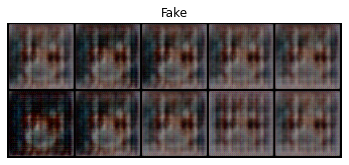

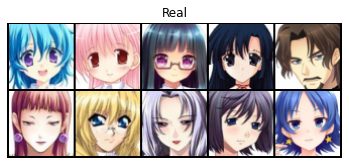

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2/6: Generator loss: 9.676, disc loss: 1.666


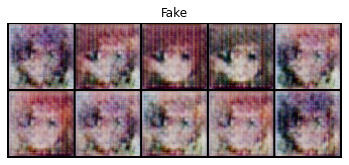

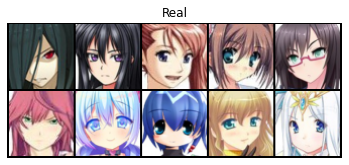

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3/6: Generator loss: 10.205, disc loss: 1.755


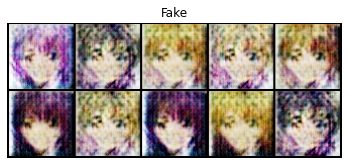

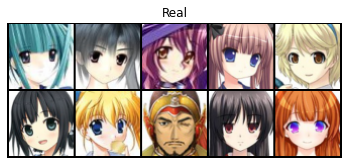

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4/6: Generator loss: 11.689, disc loss: 1.657


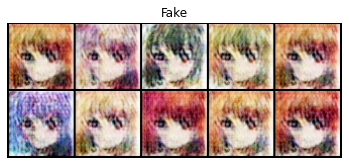

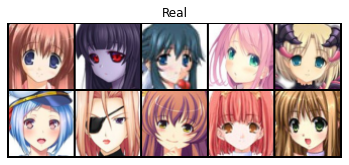

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5/6: Generator loss: 12.867, disc loss: 1.536


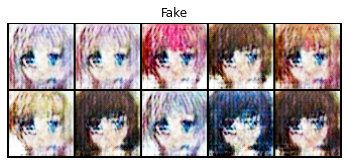

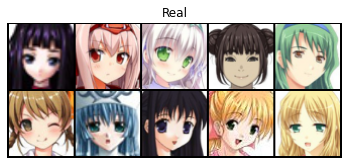

  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
n_epochs = 6        # only a small number of epochs because...you'll see. ;-)
for epoch in range(n_epochs):
    avg_gen_loss, avg_disc_loss = 0, 0             # we'll report running average losses
    for batch_idx, real in enumerate(tqdm(dataloader)): # grab batches of images
        cur_batch_size, real  = len(real), real.to(device)  # get size & move to GPU

        # Discriminator training
        disc_opt.zero_grad()                    # reset gradient info for this step
        noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(noise)                       # generate a fake image
        disc_fake_pred = disc(fake.detach())    # score that image with the Discriminator
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # zeros denoting these are supposed to be fake
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # ones denoting these are supposed to be real
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        avg_disc_loss += disc_loss.item() / cur_batch_size # keep record of disc loss
        disc_loss.backward(retain_graph=True)    # backprop: compute gradients
        disc_opt.step()                          # take the gradient descent step

        ## Generator training
        gen_opt.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device) 
        fake_2 = gen(noise)                      # generate a fake image
        disc_fake_pred = disc(fake_2)            # have the discriminator rate the fake image
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) # ones: try to make it more like "real"
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        avg_gen_loss += gen_loss.item() / cur_batch_size
        
    
    print(f"Epoch {epoch+1}/{n_epochs}: Generator loss: {avg_gen_loss:5.3f}, disc loss: {avg_disc_loss:5.3f}")
    show_batch(fake, label='Fake')
    show_batch(real, label='Real')

...We could keep training, but you'll already notice a **tendency for the fake images to mostly look alike** -- whereas we'd prefer to have a generative model that produces more variety. Training this system longer is unlikely to help with the lack of variety. This problem is what people call "mode collapse": the generator gets stuck doing the same thing over and over because it's not getting helpful gradient info from the Discriminator. Don't worry, we can do much better.


### Wasserstein Loss aka "Earth Mover" Loss to the Rescue 

To fix this problem, the idea will be to use a different loss known as the "Wasserstein Loss" or "[earth-mover](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490) loss": for two hill-shaped probability distributions, this loss corresponds to the amount of "energy" it would take (for an imaginary army of ants) to re-stack all the little "grains of sand" in one "hill" such that it formed the shape of the other hill:

![earth mover pic](https://miro.medium.com/max/438/1*9J8M6IS80nPiFSQPZKhg3Q.png)
*Image source: [Renu Khandelwal](https://medium.com/mlearning-ai/how-to-improve-image-generation-using-wasserstein-gan-1297f449ca75)*



Thus we will create a "Wasserstein GAN" or WGAN.  The required code changes are relatively minor -- see the optional Appendix below -- but there are a number of "goodies" that the fastai ["Wasserstein GAN" implementation](https://github.com/fastai/fastai/blob/master/dev_nbs/course/lesson7-wgan.ipynb) provides in terms of intelligent scheduling and performance tuning, so we will use fastai's WGAN. (And then, if you really want to DIY-it, you may do so in the Appendix.)

## FastAI WGAN Trainer

We will still keep the genenerator and discriminator you made earlier, only we will hook these up to the fastai `GANLearner.wgan`.  Also, we should mention that with WGAN's, the discriminator gets renamed the "critic", but it still serves a similar function. 



The "critic" provides more information to the generator than the discriminator did.  The latter only was judging fake-or-not.  The critic judges the distance between the (mean of) the real data distribution (per batch) and the fake data distribution, and then the generator tries to learn to minimize this distance.  



Let's get started!

In [49]:
from fastai.vision.gan import *

### FastAI DataLoaders
The documentation for fastai's WGAN recommends using the DataBlock API to setup the dataloaders:

In [60]:
"""
img_size = 64  # same as before
batch_size = 128
dls = ImageDataLoaders.from_path_func(path, fnames, label_func=lambda x:'real', bs=batch_size,
            item_tfms=[ToTensor, Resize(img_size)], batch_tfms=[Normalize.from_stats(*imagenet_stats)])

dls.show_batch()  # show what the resized/cropped images look like
"""

"\nimg_size = 64  # same as before\nbatch_size = 128\ndls = ImageDataLoaders.from_path_func(path, fnames, label_func=lambda x:'real', bs=batch_size,\n            item_tfms=[ToTensor, Resize(img_size)], batch_tfms=[Normalize.from_stats(*imagenet_stats)])\n\ndls.show_batch()  # show what the resized/cropped images look like\n"

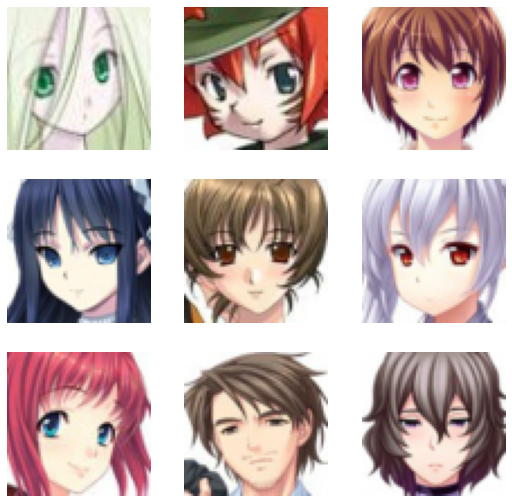

In [57]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,      # generate_noise() is defined in fastai.vision.gan
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))

def get_dls(bs, size, path=path):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=[Resize(img_size)], #, method=ResizeMethod.Crop)],
                   batch_tfms = [Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))])
    return dblock.dataloaders(path, path=path, bs=bs)


dls = get_dls(128, size, path)  # define the dataloaders -- a noise generator and an image-file-loader

dls.show_batch()  # show sample images

**Next up, a minor piece of trivia:** For the "critic" we just need to do one minor type recasting because the fastai WGAN uses a type called "InvisibleTensor" for the noise, and we need to make it so our critic-discriminator can handle that.  So all we do is define a module class so that we can add the recasting to TensorBase in the `.forward()` method in order to avoid getting runtime errors! Don't worry about this part though. 

In [53]:
class Critic(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = the_discriminator(im_chan=im_chan, hidden_dim=hidden_dim)
    def forward(self, x):
        x = TensorBase(x.transpose(-1,-1).contiguous()) # undo fastai "InvisibleTensor" shenanigans
        return self.crit(x)
    
critic = Critic()
#critic       # show the layers in the critic -- literally the same as the discriminator

In [52]:
## Fun stuff!  I wrote this custom callback to stream your sample fakes to WandB.ai:
class WandB_WGAN_Images(Callback): 
    "Progress-like callback: log WGAN predictions to WandB"
    order = ProgressCallback.order+1
    def __init__(self, n_preds=10):
        store_attr()

    def after_epoch(self):  
        if self.gen_mode:
            preds = learn.gan_trainer.last_gen.cpu()
            img_grid = make_grid(preds[:self.n_preds], nrow=5)
            img_grid = img_grid.permute(1, 2, 0).squeeze()
            wandb.log({"examples": wandb.Image(img_grid)})
            
            
wandb.init(project='anime_gan')            # initialize wandb

Now define the fatai GANLearner:

In [58]:
generator, critic = better_generator(), Critic  # define component model-parts

learn = GANLearner.wgan(dls, generator, critic, opt_func=partial(Adam, mom=0.), cbs=WandbCallback())

learn.recorder.train_metrics=True     # uhhh.. this is something you're apparently supposed to do,so...yeah!
learn.recorder.valid_metrics=False

### Do the training!

Note: In the following, "good" training metrics are when the *absolute values* of all loss functions decrease.

In [59]:
epochs = 30          # 30 epochs is fine, but 100's better if you're willing to wait
learn.fit(epochs, 2e-4, wd=0, cbs=WandB_WGAN_Images())   # fit! 

# ignore any WandbCallback messages below, don't worry about 'em

WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> list index out of range


/home/shawley/envs/fastai/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


^You can ignore any warning message about "Your generator is empty."

In [114]:
wandb.finish()                 # tie off that set of logs for that run.

In [115]:
learn.save(f'animegan-{epochs}')  # save the model in case we want it.

Path('cropped/models/animegan-50.pth')

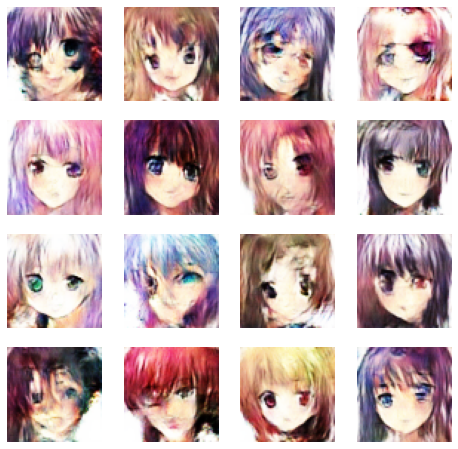

In [116]:
learn.show_results(max_n=16, figsize=(8,8), ds_idx=0)

## Inference: Generate more pics
Extract the generator part and use it as a standalone image-generator

In [ ]:
# TODO:...write some code

# (Optional) Appendix: WGAN From Scratch
This is mostly identical to the earlier "raw" PyTorch training code.  The [seemingly minor differences](https://agustinus.kristia.de/techblog/2017/02/04/wasserstein-gan/) lie in a few parts:

1. how the losses are computed
2. the fact that we "clamp" the weights in the discriminator/critic after each gradient descent step. 
3. we train the discriminator/critic "extra times" per step, compared to the generator.
3. also we no longer need to normalize the initial weights

In [61]:
dataset = AnimeDataset(path)

torch.manual_seed(0) # for making the shuffle reproduciple in case we want that.

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [62]:
# this whole cell is same as before except the weight norm is gone and I bumped up the lr a bit
z_dim = 100
batch_size = 128
lr = 0.0005
device = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = better_generator(z_dim).to(device)
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)

disc = the_discriminator().to(device)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lr*2)

***WARNING:*** *The fastai training loop includes performance enhancements that the following code lacks. This will take about 3 to 6 minutes per epoch.*

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/15: Generator loss: 0.191, disc loss: -0.901


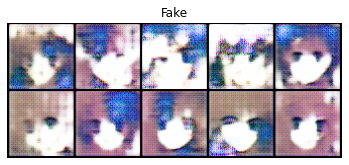

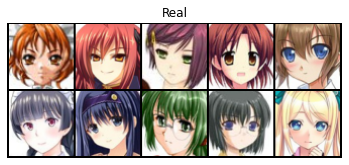

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3/15: Generator loss: 0.037, disc loss: -0.466


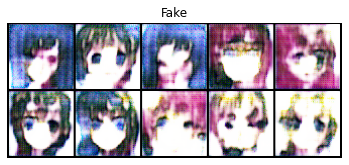

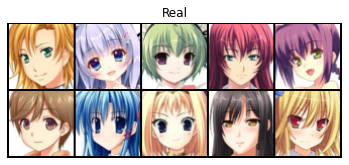

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5/15: Generator loss: -0.020, disc loss: -0.081


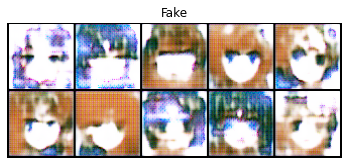

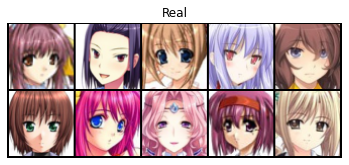

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7/15: Generator loss: -0.002, disc loss: -0.146


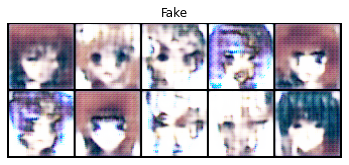

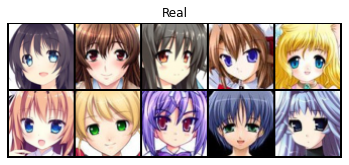

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9/15: Generator loss: 0.090, disc loss: -0.426


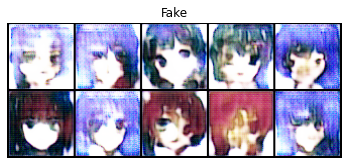

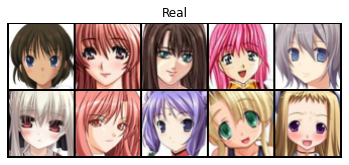

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11/15: Generator loss: -0.037, disc loss: -0.032


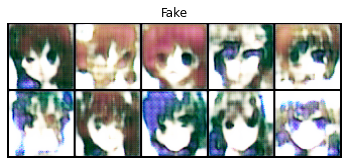

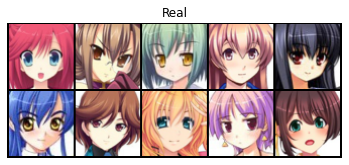

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 13/15: Generator loss: -0.030, disc loss: -0.036


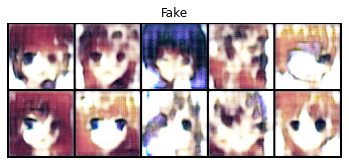

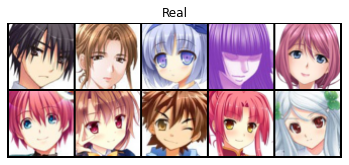

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 15/15: Generator loss: 0.014, disc loss: -0.021


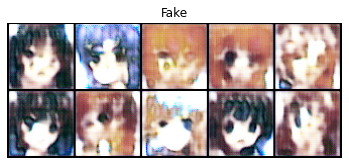

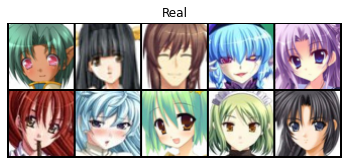

In [63]:
# WGAN VERSION
n_epochs = 15  
n_crit = 3                      # number of times we train the critic per batch of reals
for epoch in range(n_epochs):
    mean_gen_loss, mean_disc_loss = 0, 0 
    for batch_idx, real in enumerate(tqdm(dataloader)): # grab batches of images
        cur_batch_size, real  = len(real), real.to(device)  # get size & move to GPU

        ## Critic Training
        for i in range(n_crit):  # WGAN: multiple passes training the critic
            if i > 0:
                real = next(iter(dataloader))  # grab a new batch of real data
                disc_batch_size, real  = len(real), real.to(device)
            else:
                disc_batch_size = cur_batch_size
                
            disc_opt.zero_grad()                    # reset gradient info for this step
            noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(noise)                       # generate a fake image
            disc_fake_pred = disc(fake.detach())    # score that image with the Discriminator
            disc_real_pred = disc(real)
            #disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # zeros denoting these are supposed to be fake
            #disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # ones denoting these are supposed to be real
            #disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss = -(torch.mean(disc_real_pred) - torch.mean(disc_fake_pred)) # WGAN disc loss
            mean_disc_loss += disc_loss.item() / disc_batch_size # keep record of disc loss
            disc_loss.backward(retain_graph=True)    # backprop: compute gradients
            disc_opt.step()                          # take the gradient descent step
            for p in disc.parameters():              # WGAN: clip all the weights at [-0.01,0.01]
                p.data.clamp_(-0.01, 0.01)

                
        ## Generator training
        gen_opt.zero_grad()
        noise = get_noise(cur_batch_size, z_dim, device=device) 
        fake_2 = gen(noise)                      # generate a fake image
        disc_fake_pred = disc(fake_2)            # have the discriminator rate the fake image
        #gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) # ones: try to make it more like "real"
        gen_loss = -(torch.mean(disc_fake_pred))  # WGAN gen loss
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_gen_loss += gen_loss.item() / cur_batch_size
    
    if epoch % 2 == 0: # only show images for every other epoch
        print(f"Epoch {epoch+1}/{n_epochs}: Generator loss: {mean_gen_loss:5.3f}, disc loss: {mean_disc_loss:5.3f}")
        show_batch(fake, label='Fake')
        show_batch(real, label='Real')

...So, we see more variety that our earlier "from scratch" GAN, but not as good as the fastai-powered WGAN.  That's because there are still a significant number of "tricks" people use to get better results, which fastai includes but that we didn't cover here. For further reading on such things, see.... # TODO